In [58]:
import numpy as np
import itertools
import math
import scipy
from scipy import spatial
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
import matplotlib.cm as cm
from matplotlib import animation
from matplotlib import transforms
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import dask
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import netCDF4
from skimage.metrics import structural_similarity as ssim
import warnings
warnings.filterwarnings("ignore")
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [59]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

In [60]:
def interpolate_points(p1, p2, n_steps=100):
    "linear interpolation -- https://openreview.net/pdf?id=S1fQSiCcYm"
    ratios = np.linspace(0, 1, num=n_steps)
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return np.asarray(vectors)


def slerp(count, low, high):
    """Spherical interpolation. val has a range of 0 to 1."""
    values = np.linspace(0, 1, num=count)
    output_array = np.empty(shape=(count,low.size))
    for i in range(len(values)):
        val = values[i]
        omega = np.arccos(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)))
        so = np.sin(omega)
        output_array[i,:] = np.sin((1.0-val)*omega) / so * low + np.sin(val*omega)/so * high
    return output_array

In [61]:
others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc")
levs = np.array(others.variables['lev'])
new = np.flip(levs)
crms = np.arange(1,129,1)
Xs, Zs = np.meshgrid(crms, new)

In [62]:
def plot_generator_paper(sample, X, Z):
    
    fz = 15*1.25
    lw = 4
    siz = 100
    XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
    XTEXT = 0.25 # Text placement
    YTEXT = 0.3 # Text placement
    
    plt.rc('text', usetex=False)
    matplotlib.rcParams['mathtext.fontset'] = 'stix'
    matplotlib.rcParams['font.family'] = 'STIXGeneral'
    #mpl.rcParams["font.serif"] = "STIX"
    plt.rc('font', family='serif', size=fz)
    matplotlib.rcParams['lines.linewidth'] = lw
    
    
    cmap="RdBu_r"
    fig, ax = plt.subplots(1,1, figsize=(15,6))
    cs0 = ax.pcolor(X, Z, sample, cmap=cmap, vmin=-1.0, vmax = 1.0)
    ax.set_title("Anomalous Vertical Velocity Field Detected By ELBO")
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_xlabel("CRMs", fontsize=fz*1.5)
    ax.xaxis.set_label_coords(0.54,-0.05)
    h = ax.set_ylabel("hPa", fontsize = fz*1.5)
    h.set_rotation(0)
    ax.yaxis.set_label_coords(-0.10,0.44)
    #y_ticks = np.arange(1350, 0, -350)
    #ax.set_yticklabels(y_ticks, fontsize=fz*1.33)
    ax.tick_params(axis='x', labelsize=fz*1.33)
    ax.tick_params(axis='y', labelsize=fz*1.33)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(cs0, cax=cax)
    cbar.set_label(label=r'$\left(\mathrm{m\ s^{-1}}\right)$', rotation="horizontal", fontsize=fz*1.5, labelpad=30, y = 0.65)
    plt.show()
    #plt.savefig("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/CI_Figure_Data/Anomaly.pdf")
    
#plot_generator(test[0,:,:])

In [77]:
z_test_tsne = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Synoptic_Latent_Spaces/2D_PCA_Latent_Space__31.npy")

Diurnal_Amazon_W_Test_2D = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Synoptic_Latent_Spaces/Synoptic_Amazon_Centered_50_50_Point_2D_PCA_Latent_Space__31.npy")[:96,:]
#Diurnal_Amazon_W_Test_2D = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Synoptic_Latent_Spaces/Synoptic_Amazon_Centered_50_50_Point_2D_PCA_Latent_Space__31.npy")


Test_Images = np.load("/fast/gmooers/Preprocessed_Data/Single_Amazon_Unaveraged/synoptic_amazon_point.npy")
Max_Scalar = np.load("/fast/gmooers/Preprocessed_Data/Centered_50_50/Space_Time_Max_Scalar.npy")
Min_Scalar = np.load("/fast/gmooers/Preprocessed_Data/Centered_50_50/Space_Time_Min_Scalar.npy")
Test_Images = np.interp(Test_Images, (0, 1), (Min_Scalar, Max_Scalar))

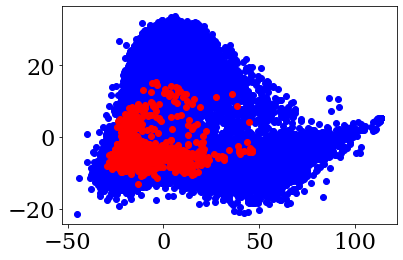

In [78]:
plt.scatter(z_test_tsne[:,0], z_test_tsne[:,1], c="blue")
plt.scatter(Diurnal_Amazon_W_Test_2D[:,0], Diurnal_Amazon_W_Test_2D[:,1], c="red")

In [64]:
Test_Day = Test_Images[:96,:,:]
#for i in range(len(Test_Day)):
#    plot_generator_paper(np.squeeze(Test_Day[i,:,:]),Xs,Zs)

In [65]:
Truth_Inbetween = Test_Day[1::2,:,:]

In [66]:
Full_Image_Linear_Interp = np.empty(shape=(96*15,30,128))
Full_Image_Spherical_Interp = np.empty(shape=(96*15,30,128))
for i in range(len(Truth_Inbetween)-1):
    starter = np.squeeze(Truth_Inbetween[i,:,:])
    ender = np.squeeze(Truth_Inbetween[i+1,:,:])
    
    linear = interpolate_points(starter, ender, 30)
    spherical = slerp(30, starter.flatten(), ender.flatten())
    Full_Image_Linear_Interp[30*i:30*(i+1),:,:] = linear
    Full_Image_Spherical_Interp[30*i:30*(i+1),:,:] = np.reshape(spherical, (30,30,128))
    

In [67]:
linear_path = "/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Interpolation_Data/Amazon_Day_30_Minutes/linear_hov_muller_31_Reconstructed_Images_W_Comp_"
sphere_path = "/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Interpolation_Data/Amazon_Day_30_Minutes/spherical_hov_muller_31_Reconstructed_Images_W_Comp_"


number = 48
linear_interps = np.empty(shape=(48*30,30,128))
sphere_interps = np.empty(shape=(48*30,30,128))
count = 0
for i in range(number):
    interp = np.load(sphere_path+str(count)+'_'+str(count+2)+".npy")
    interp = np.reshape(interp, (30,30,128))
    sphere_interps[30*i:30*(i+1),:] = np.squeeze(interp[:,:,:])
    
    interp = np.load(linear_path+str(count)+'_'+str(count+2)+".npy")
    interp = np.reshape(interp, (30,30,128))
    linear_interps[30*i:30*(i+1),:] = np.squeeze(interp[:,:,:])
    count = count+2

In [68]:
scaled_linear_interps = np.interp(linear_interps, (0, 1), (Min_Scalar, Max_Scalar))
scaled_sphere_interps = np.interp(sphere_interps, (0, 1), (Min_Scalar, Max_Scalar))

In [69]:
test_linear_interps = scaled_linear_interps[15::30,:,:]
test_sphere_interps = scaled_sphere_interps[15::30,:,:]
test_image_linear_interps = Full_Image_Linear_Interp[15::30,:,:]
test_image_sphere_interps = Full_Image_Spherical_Interp[15::30,:,:]

In [70]:
print(np.min(test_linear_interps),np.max(test_linear_interps))
print(np.min(test_sphere_interps),np.max(test_sphere_interps))
print(np.min(test_image_linear_interps),np.max(test_image_linear_interps))
print(np.min(test_image_sphere_interps),np.max(test_image_sphere_interps))
print(np.min(Truth_Inbetween),np.max(Truth_Inbetween))

-1.4031505419957284 3.29886286994315
-2.1740465921639043 5.627905030443401
-2.1091415799897293 3.600644691237086
-2.8567088703212304 4.603686342303701
-4.11311674118042 6.086562633514401


In [71]:
def MSE(A,B):
    mse = np.linalg.norm(A - B)
    return mse

def SSIM(A,B):
    return ssim(A,B)

def Timestep_time_gen(starter):
    if starter == 96:
        starter = 0
    
    time = str(int(starter/4))
    remainder = starter % 4
    if remainder == 0:
        decimal =":00 LST"
    if remainder == 1:
        decimal =":15 LST"
    if remainder == 2:
        decimal =":30 LST"
    if remainder == 3:
        decimal =":45 LST"
    new_time = time + decimal
    return new_time

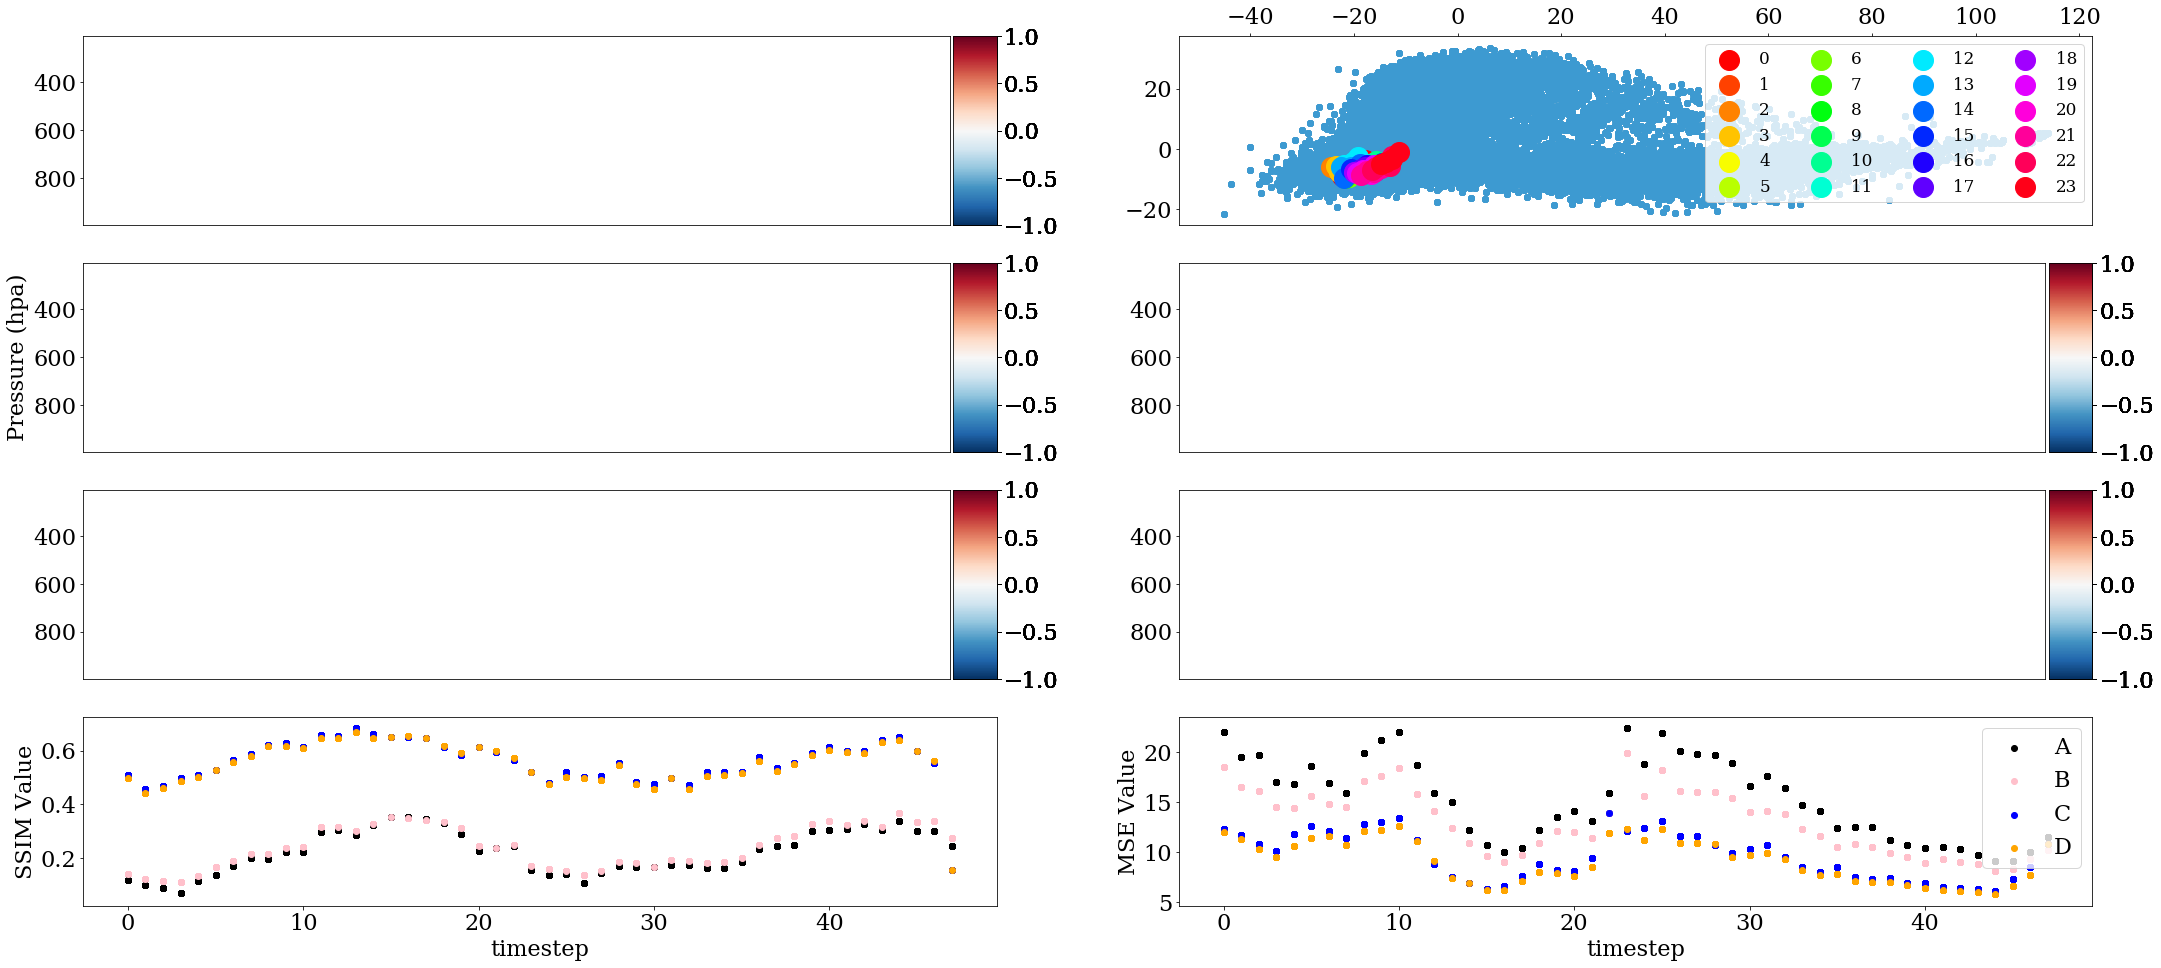

In [75]:
# change vx/vy to location on sorted images
def mikes_horz_latent_animation(starter, gap, latent_space, X, Z, linear_o_images, sphere_o_images,linear_z_images, sphere_z_images, true_images, h_coords):
    colors = cm.hsv(np.linspace(0, 1, int(len(h_coords)/4)))
    bc_labels = ["0","1","2","3", "4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","23"]

    fig, ax = plt.subplots(4,2, figsize=(36,16))
    feat_list = []
    #the real total you need
    num_steps = len(linear_o_images)
    #num_steps = 10
    cmap= "RdBu_r"
    
    sphere_z_mse = np.empty(shape=(len(linear_o_images)))
    linear_z_mse = np.empty(shape=(len(linear_o_images)))
    sphere_o_mse = np.empty(shape=(len(linear_o_images)))
    linear_o_mse = np.empty(shape=(len(linear_o_images)))
    
    sphere_z_ssim = np.empty(shape=(len(linear_o_images)))
    linear_z_ssim = np.empty(shape=(len(linear_o_images)))
    sphere_o_ssim = np.empty(shape=(len(linear_o_images)))
    linear_o_ssim = np.empty(shape=(len(linear_o_images)))
    
    for i in range(len(linear_o_images)):
        sphere_z_mse[i] = MSE(np.squeeze(true_images[i,:,:]), np.squeeze(sphere_z_images[i,:,:]))
        linear_z_mse[i] = MSE(np.squeeze(true_images[i,:,:]), np.squeeze(linear_z_images[i,:,:]))
        sphere_o_mse[i] = MSE(np.squeeze(true_images[i,:,:]), np.squeeze(sphere_o_images[i,:,:]))
        linear_o_mse[i] = MSE(np.squeeze(true_images[i,:,:]), np.squeeze(linear_o_images[i,:,:]))
        sphere_z_ssim[i] = SSIM(np.squeeze(true_images[i,:,:]), np.squeeze(sphere_z_images[i,:,:]))
        linear_z_ssim[i] = SSIM(np.squeeze(true_images[i,:,:]), np.squeeze(linear_z_images[i,:,:]))
        sphere_o_ssim[i] = SSIM(np.squeeze(true_images[i,:,:]), np.squeeze(sphere_o_images[i,:,:]))
        linear_o_ssim[i] = SSIM(np.squeeze(true_images[i,:,:]), np.squeeze(linear_o_images[i,:,:]))
        
    
    dummy_linear_o_images = np.empty(shape=(30,128))
    dummy_sphere_o_images = np.empty(shape=(30,128))
    dummy_linear_z_images = np.empty(shape=(30,128))
    dummy_sphere_z_images = np.empty(shape=(30,128))
    dummy_truth_start_images = np.empty(shape=(30,128))
    
    count = 29

    for i in range(num_steps):
        for j in range(len(dummy_linear_o_images)):
            dummy_linear_o_images[count,:] = linear_o_images[i,j,:]
            dummy_sphere_o_images[count,:] = sphere_o_images[i,j,:]
            dummy_linear_z_images[count,:] = linear_z_images[i,j,:]
            dummy_sphere_z_images[count,:] = sphere_z_images[i,j,:]
            dummy_truth_start_images[count,:] = true_images[i,j,:]
          
            count = count-1
        
        h_rect = patches.Circle((h_coords[1+i*2, 0],h_coords[1+i*2, 1]),0.5,linewidth=4,edgecolor='black',facecolor='black')

        
        y_ticks = np.array([1000, 800, 600, 400, 200])
        
        ax[0,1].scatter(latent_space[:, 0], latent_space[:, 1], c="#3D9AD1", alpha=0.5, animated=True)
        
        counter = -1
        for a in range(len(h_coords)):
            if a%4 == 0:
                counter = counter+1
                cb = ax[0,1].scatter(x=h_coords[a, 0], y=h_coords[a, 1], c=colors[counter], s=400, label=str(int(a/4)), animated=True)
            else:
                cb = ax[0,1].scatter(x=h_coords[a, 0], y=h_coords[a, 1], c=colors[counter], s=400, animated = True)
             
        if i ==0:
            ax[0,1].legend(loc="best", ncol=4, fontsize=fz*0.75)
        
        #ax[0,0].scatter(x=h_coords[starter, 0], y=h_coords[starter, 1], c="Black", s=500.0, marker=(5, 2), animated=True)
        #ax[0,0].scatter(x=h_coords[starter+gap,0], y=h_coords[starter+gap, 1], c="Black", s=500.0, marker=(5, 2), animated=True)

        cs0 = ax[0,1].add_patch(h_rect)
        
        if starter >= 96:
            starter = 0
        timestart = Timestep_time_gen(starter+i*2)
        
        cs1  = ax[1,0].pcolor(X, Z, dummy_sphere_z_images, cmap=cmap, animated=True, vmin = -1.0, vmax = 1.0)
        title_0 = ax[1,0].text(0.5,1.05,"(A) Sphericaly Interpolated z vector at ".format(i)+timestart.format(i), size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax[1,0].transAxes, fontsize=fz)
        ax[1,0].set_yticklabels(y_ticks)
        divider = make_axes_locatable(ax[1,0])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(cs1, cax=cax)
        
        cs4  = ax[1,1].pcolor(X, Z, dummy_linear_z_images, cmap=cmap, animated=True, vmin = -1.0, vmax = 1.0)
        title_5 = ax[1,1].text(0.5,1.05,"(B) Linearly Interpolated z vector at ".format(i)+timestart.format(i), size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax[1,1].transAxes, fontsize=fz)
        ax[1,1].set_yticklabels(y_ticks)
        divider = make_axes_locatable(ax[1,1])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(cs4, cax=cax)
        
        cs5  = ax[2,0].pcolor(X, Z, dummy_sphere_o_images, cmap=cmap, animated=True, vmin = -1.0, vmax = 1.0)
        title_3 = ax[2,0].text(0.5,1.05,"(C) Sphericaly Interpolated Vertical Velocity Field at ".format(i)+timestart.format(i), size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax[2,0].transAxes, fontsize=fz)
        ax[2,0].set_yticklabels(y_ticks)
        divider = make_axes_locatable(ax[2,0])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(cs5, cax=cax)
        
        cs6  = ax[2,1].pcolor(X, Z, dummy_linear_o_images, cmap=cmap, animated=True, vmin = -1.0, vmax = 1.0)
        title_4 = ax[2,1].text(0.5,1.05,"(D) Linearly Interpolated Vertical Velocity Field at ".format(i)+timestart.format(i), size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax[2,1].transAxes, fontsize=fz)
        ax[2,1].set_yticklabels(y_ticks)
        divider = make_axes_locatable(ax[2,1])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(cs6, cax=cax)
        
        cs2  = ax[0,0].pcolor(X, Z, dummy_truth_start_images, cmap=cmap, animated=True, vmin = -1.0, vmax = 1.0)
        title_1 = ax[0,0].text(0.5,1.05,"True Convection at ".format(i)+timestart.format(i), size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax[0,0].transAxes, fontsize=fz)
        #ax[0,0].set_xlabel("CRMs", fontsize=fz)
        ax[1,0].set_ylabel("Pressure (hpa)", fontsize=fz)
        ax[0,0].set_yticklabels(y_ticks)
        divider = make_axes_locatable(ax[0,0])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(cs2, cax=cax)
        
        ax[0,0].set_xticks([])
        ax[1,0].set_xticks([])
        ax[1,1].set_xticks([])
        ax[2,0].set_xticks([])
        ax[2,1].set_xticks([])
        ax[0,1].xaxis.tick_top()
        
        ax[3,0].set_xlabel("timestep")
        ax[3,0].set_ylabel("SSIM Value")
        
        ax[3,0].scatter(np.arange(len(linear_o_images)), sphere_z_ssim, label="A", color="Black")
        ax[3,0].scatter(np.arange(len(linear_o_images)), linear_z_ssim, label="B", color="pink")
        ax[3,0].scatter(np.arange(len(linear_o_images)), sphere_o_ssim, label="C", color="Blue")
        ax[3,0].scatter(np.arange(len(linear_o_images)), linear_o_ssim, label="D", color="orange")
        
        cs7 = ax[3,0].axvline(x=i, animated=True)
        title_6 = ax[3,0].text(0.5,1.05,"SSIM Value at every timestep", size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax[3,0].transAxes, fontsize=fz)
        if i == 0:
            ax[3,1].scatter(np.arange(len(linear_o_images)), sphere_z_mse, label="A", color="Black")
            ax[3,1].scatter(np.arange(len(linear_o_images)), linear_z_mse, label="B", color="pink")
            ax[3,1].scatter(np.arange(len(linear_o_images)), sphere_o_mse, label="C", color="Blue")
            ax[3,1].scatter(np.arange(len(linear_o_images)), linear_o_mse, label="D", color="orange")
        else:
            ax[3,1].scatter(np.arange(len(linear_o_images)), sphere_z_mse, color="Black")
            ax[3,1].scatter(np.arange(len(linear_o_images)), linear_z_mse, color="pink")
            ax[3,1].scatter(np.arange(len(linear_o_images)), sphere_o_mse, color="Blue")
            ax[3,1].scatter(np.arange(len(linear_o_images)), linear_o_mse, color="orange")
            
        title_7 = ax[3,1].text(0.5,1.05,"MSE Value at every timestep", size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax[3,1].transAxes, fontsize=fz)
        ax[3,1].set_xlabel("timestep")
        ax[3,1].set_ylabel("MSE Value")
        ax[3,1].legend()
        cs8 = ax[3,1].axvline(x=i, animated=True)
        
        feat_list.append([cs2, cs1, cs0, cs4, cs5, cs6, cs7, cs8, title_0, title_1, title_3, title_4, title_5, title_6, title_7])

        count = 29 
  
    ani = animation.ArtistAnimation(fig, feat_list, interval = 125, blit = False, repeat = True)
    ani.save('/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Animations/Figures/Movies/Interpolation_Quantitative_30_Minutes_Day.mp4')
    plt.show()
        
    
mikes_horz_latent_animation(1, 2, z_test_tsne, Xs, Zs, test_image_linear_interps, test_image_sphere_interps, test_linear_interps, test_sphere_interps, Truth_Inbetween, Diurnal_Amazon_W_Test_2D)

In [80]:
test_linear_interps_500 = np.squeeze(test_linear_interps[:,-12,:])
test_sphere_interps_500 = np.squeeze(test_sphere_interps[:,-12,:])
test_image_linear_interps_500 = np.squeeze(test_image_linear_interps[:,-12,:])
test_image_sphere_interps_500 = np.squeeze(test_image_sphere_interps[:,-12,:])

In [84]:
sphere_z_mse = np.empty(shape=(len(test_linear_interps)))
linear_z_mse = np.empty(shape=(len(test_linear_interps)))
sphere_o_mse = np.empty(shape=(len(test_linear_interps)))
linear_o_mse = np.empty(shape=(len(test_linear_interps)))
    
sphere_z_ssim = np.empty(shape=(len(test_linear_interps)))
linear_z_ssim = np.empty(shape=(len(test_linear_interps)))
sphere_o_ssim = np.empty(shape=(len(test_linear_interps)))
linear_o_ssim = np.empty(shape=(len(test_linear_interps)))
    
for i in range(len(test_linear_interps)):
    sphere_z_mse[i] = MSE(np.squeeze(Truth_Inbetween[i,-12,:]), np.squeeze(test_sphere_interps_500[i,:]))
    linear_z_mse[i] = MSE(np.squeeze(Truth_Inbetween[i,-12,:]), np.squeeze(test_linear_interps_500[i,:]))
    sphere_o_mse[i] = MSE(np.squeeze(Truth_Inbetween[i,-12,:]), np.squeeze(test_image_sphere_interps_500[i,:]))
    linear_o_mse[i] = MSE(np.squeeze(Truth_Inbetween[i,-12,:]), np.squeeze(test_image_linear_interps_500[i,:]))
    sphere_z_ssim[i] = SSIM(np.squeeze(Truth_Inbetween[i,-12,:]), np.squeeze(test_sphere_interps_500[i,:]))
    linear_z_ssim[i] = SSIM(np.squeeze(Truth_Inbetween[i,-12,:]), np.squeeze(test_linear_interps_500[i,:]))
    sphere_o_ssim[i] = SSIM(np.squeeze(Truth_Inbetween[i,-12,:]), np.squeeze(test_image_sphere_interps_500[i,:]))
    linear_o_ssim[i] = SSIM(np.squeeze(Truth_Inbetween[i,-12,:]), np.squeeze(test_image_linear_interps_500[i,:]))

Text(0.5, 1.0, 'SSIM Value at every timestep')

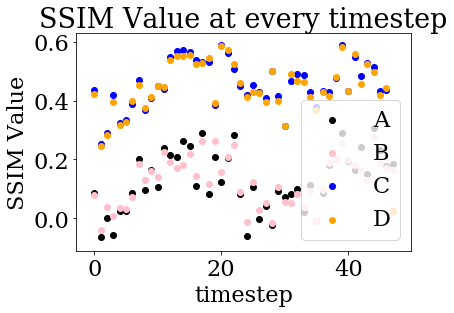

In [85]:
plt.xlabel("timestep")
plt.ylabel("SSIM Value")
        
plt.scatter(np.arange(len(test_linear_interps)), sphere_z_ssim, label="A", color="Black")
plt.scatter(np.arange(len(test_linear_interps)), linear_z_ssim, label="B", color="pink")
plt.scatter(np.arange(len(test_linear_interps)), sphere_o_ssim, label="C", color="Blue")
plt.scatter(np.arange(len(test_linear_interps)), linear_o_ssim, label="D", color="orange")
plt.legend()
plt.title("SSIM Value at every timestep")        


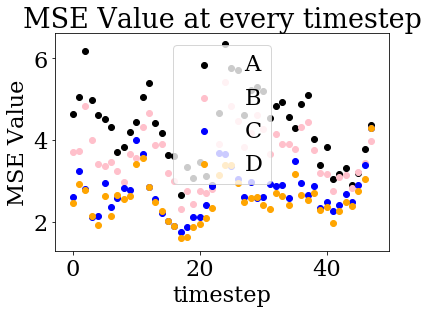

In [86]:

plt.scatter(np.arange(len(test_linear_interps)), sphere_z_mse, label="A", color="Black")
plt.scatter(np.arange(len(test_linear_interps)), linear_z_mse, label="B", color="pink")
plt.scatter(np.arange(len(test_linear_interps)), sphere_o_mse, label="C", color="Blue")
plt.scatter(np.arange(len(test_linear_interps)), linear_o_mse, label="D", color="orange")
plt.title("MSE Value at every timestep")
plt.xlabel("timestep")
plt.ylabel("MSE Value")
plt.legend()